In [ ]:
# Установка библиотеки для Process mining
!pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26099 sha256=e0bf5267348d2964ab8b9862700b4514b8c27782d85a29766efe0f4d541f8c8a
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for stringdist: filename=StringDist-1.0.9-cp310-cp310-linux_x86_64.whl size=24955 sha256=ca94a70f24f101868a430398ff5707fb4fdf99873b85165a28623af31faee193
  Stored in directory: /root/.cache/pip/wheels/79/25/0a/4a0c2c7af31a8b473f6e10e30312396f31ae899722600d7b99
Successfully built intervaltree stringdist


In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
log_csv = pd.read_csv('https://data.4tu.nl/file/657fb1d6-b4c2-4adc-ba48-ed25bf313025/bd6cfa31-44f8-4542-9bad-f1f70c894728', sep= ";", index_col = "Incident ID")

**Предобработка данных**

In [ ]:
# Преобразуем тип данных в колонке DateTime в специальных формат даты и времени библиотеки Pandas
log_csv['DateStamp'] = pd.to_datetime(log_csv['DateStamp'])

In [ ]:
log_csv

,DateStamp,IncidentActivity_Number,IncidentActivity_Type,Assignment Group,KM number,Interaction ID
Incident ID,,,,,,
IM0000004,2013-07-01 08:17:17,001A3689763,Reassignment,TEAM0001,KM0000553,SD0000007
IM0000004,2013-04-11 13:41:30,001A5852941,Reassignment,TEAM0002,KM0000553,SD0000007
IM0000004,2013-04-11 13:41:30,001A5852943,Update from customer,TEAM0002,KM0000553,SD0000007
IM0000004,2013-04-11 12:09:37,001A5849980,Operator Update,TEAM0003,KM0000553,SD0000007
IM0000004,2013-04-11 12:09:37,001A5849979,Assignment,TEAM0003,KM0000553,SD0000007
...,...,...,...,...,...,...
IM0047056,2014-03-31 15:42:37,001A6917801,Closed,TEAM0191,KM0001287,SD0146986
IM0047057,2014-03-31 17:24:50,001A6919138,Open,TEAM0199,KM0000182,SD0147088
IM0047057,2014-03-31 17:25:07,001A6919139,Update,TEAM0199,KM0000182,SD0147088


In [ ]:
# Создаем сгруппированную таблицу с начальной отметкой времени и конечной для каждого case
case_starts_ends = log_csv.pivot_table(index='Incident ID', aggfunc={'DateStamp': ['min', 'max']}) 

case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['Incident ID', 'caseend', 'casestart'] 
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='Incident ID') 
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['relativetime'] = log_csv['DateStamp'] - log_csv['casestart']

log_csv['relativetime_s'] = log_csv['relativetime'].dt.seconds + 86400*log_csv['relativetime'].dt.days 

log_csv['relativedays'] = log_csv['relativetime'].dt.days

log_csv['caselength'] = log_csv['caseend'] - log_csv['casestart']

log_csv

,Incident ID,DateStamp,IncidentActivity_Number,IncidentActivity_Type,Assignment Group,KM number,Interaction ID,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,IM0000004,2013-07-01 08:17:17,001A3689763,Reassignment,TEAM0001,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,80 days 20:07:40,6984460,80,166 days 20:18:03
1,IM0000004,2013-04-11 13:41:30,001A5852941,Reassignment,TEAM0002,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 01:31:53,5513,0,166 days 20:18:03
2,IM0000004,2013-04-11 13:41:30,001A5852943,Update from customer,TEAM0002,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 01:31:53,5513,0,166 days 20:18:03
3,IM0000004,2013-04-11 12:09:37,001A5849980,Operator Update,TEAM0003,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 00:00:00,0,0,166 days 20:18:03
4,IM0000004,2013-04-11 12:09:37,001A5849979,Assignment,TEAM0003,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 00:00:00,0,0,166 days 20:18:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
466732,IM0047056,2014-03-31 15:42:37,001A6917801,Closed,TEAM0191,KM0001287,SD0146986,2014-03-31 15:42:37,2014-03-31 15:35:36,0 days 00:07:01,421,0,0 days 00:07:01
466733,IM0047057,2014-03-31 17:24:50,001A6919138,Open,TEAM0199,KM0000182,SD0147088,2014-03-31 22:47:33,2014-03-31 17:24:50,0 days 00:00:00,0,0,0 days 05:22:43
466734,IM0047057,2014-03-31 17:25:07,001A6919139,Update,TEAM0199,KM0000182,SD0147088,2014-03-31 22:47:33,2014-03-31 17:24:50,0 days 00:00:17,17,0,0 days 05:22:43
466735,IM0047057,2014-03-31 22:47:33,001A6922086,Closed,TEAM0134,KM0000182,SD0147088,2014-03-31 22:47:33,2014-03-31 17:24:50,0 days 05:22:43,19363,0,0 days 05:22:43


In [ ]:
#количество инцидентов

len(log_csv['Incident ID'].unique())

46616

In [ ]:
# Переименуем колонки в соответсвии с требованиями Process mining
log_csv.rename(columns=
                {'DateStamp': 'time:timestamp',
                 'Incident ID': 'case:concept:name',
                 'IncidentActivity_Type': 'concept:name',
                 'Assignment Group': 'org:resource'},
                inplace=True)

log_csv

,case:concept:name,time:timestamp,IncidentActivity_Number,concept:name,org:resource,KM number,Interaction ID,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,IM0000004,2013-07-01 08:17:17,001A3689763,Reassignment,TEAM0001,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,80 days 20:07:40,6984460,80,166 days 20:18:03
1,IM0000004,2013-04-11 13:41:30,001A5852941,Reassignment,TEAM0002,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 01:31:53,5513,0,166 days 20:18:03
2,IM0000004,2013-04-11 13:41:30,001A5852943,Update from customer,TEAM0002,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 01:31:53,5513,0,166 days 20:18:03
3,IM0000004,2013-04-11 12:09:37,001A5849980,Operator Update,TEAM0003,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 00:00:00,0,0,166 days 20:18:03
4,IM0000004,2013-04-11 12:09:37,001A5849979,Assignment,TEAM0003,KM0000553,SD0000007,2013-09-25 08:27:40,2013-04-11 12:09:37,0 days 00:00:00,0,0,166 days 20:18:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
466732,IM0047056,2014-03-31 15:42:37,001A6917801,Closed,TEAM0191,KM0001287,SD0146986,2014-03-31 15:42:37,2014-03-31 15:35:36,0 days 00:07:01,421,0,0 days 00:07:01
466733,IM0047057,2014-03-31 17:24:50,001A6919138,Open,TEAM0199,KM0000182,SD0147088,2014-03-31 22:47:33,2014-03-31 17:24:50,0 days 00:00:00,0,0,0 days 05:22:43
466734,IM0047057,2014-03-31 17:25:07,001A6919139,Update,TEAM0199,KM0000182,SD0147088,2014-03-31 22:47:33,2014-03-31 17:24:50,0 days 00:00:17,17,0,0 days 05:22:43
466735,IM0047057,2014-03-31 22:47:33,001A6922086,Closed,TEAM0134,KM0000182,SD0147088,2014-03-31 22:47:33,2014-03-31 17:24:50,0 days 05:22:43,19363,0,0 days 05:22:43


In [ ]:
# введем задержку в 0,1 секунды в действии "Закрыто", так чтобы оно всегда происходило после действия "Вызвано CI".
import datetime

delta = pd.Timedelta(seconds=0.1)

# Filter the rows where 'concept:name' is 'Closed' and update 'time:timestamp'
log_csv.loc[log_csv['concept:name'] == 'Closed', 'time:timestamp'] += delta


In [ ]:
# удалим из журнала событий незакрытые кейсы

# Filter the incidents where 'concept:name' is equal to 'Closed'
closed_incidents = log_csv[log_csv['concept:name'] == 'Closed']['case:concept:name'].unique()

# Filter and keep only the incidents with 'concept:name' equal to 'Closed'
log_csv = log_csv[log_csv['case:concept:name'].isin(closed_incidents)]

In [ ]:
incident_events = pd.crosstab(log_csv['case:concept:name'], log_csv['concept:name']) 
incident_events.sum()

concept:name
Affected CI Change                184
Analysis/Research                 981
Assignment                      88247
Callback Request                   53
Caused By CI                    34382
Closed                          50145
Communication with customer      6142
Communication with vendor        1737
Contact Change                     32
Description Update               4470
Dial-in                             2
External Vendor Assignment       3842
External Vendor Reassignment       33
External update                  1099
Impact Change                    1276
Incident reproduction              23
Mail to Customer                 3788
Notify By Change                  281
OO Response                        33
Open                            46158
Operator Update                 56149
Pending vendor                   3842
Problem Closure                    40
Problem Workaround                140
Quality Indicator                2465
Quality Indicator Fixed          7791

In [ ]:
incident_events.sum(axis=1).sort_values()

case:concept:name
IM0000033      1
IM0038821      2
IM0038846      2
IM0038823      2
IM0038726      2
            ... 
IM0005897    165
IM0000220    170
IM0004038    171
IM0000382    175
IM0000428    178
Length: 46167, dtype: int64

In [ ]:
log_csv[log_csv['case:concept:name'] == 'IM0000033']

,case:concept:name,time:timestamp,IncidentActivity_Number,concept:name,org:resource,KM number,Interaction ID,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
241,IM0000033,2013-11-30 10:39:10.100,001A6062488,Closed,TEAM0008,KM0001430,SD0000056,2013-11-30 10:39:10,2013-11-30 10:39:10,0 days,0,0,0 days


In [ ]:
log_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463777 entries, 0 to 466736
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   case:concept:name        463777 non-null  object         
 1   time:timestamp           463777 non-null  datetime64[ns] 
 2   IncidentActivity_Number  463777 non-null  object         
 3   concept:name             463777 non-null  object         
 4   org:resource             463777 non-null  object         
 5   KM number                463777 non-null  object         
 6   Interaction ID           463777 non-null  object         
 7   caseend                  463777 non-null  datetime64[ns] 
 8   casestart                463777 non-null  datetime64[ns] 
 9   relativetime             463777 non-null  timedelta64[ns]
 10  relativetime_s           463777 non-null  int64          
 11  relativedays             463777 non-null  int64          
 12  ca

**Process mining**

In [ ]:
# Преобразуем DataFrame в формат журнала Process mining
event_log = log_converter.apply(log_csv)

In [ ]:
# Количество различных событий в нашем журнале событий

len(log_csv)

463777

In [ ]:
# Количество всех кейсов в нашем журнале событий

len(event_log)

46167

In [ ]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities_teams = attributes_filter.get_attribute_values(log_csv, "org:resource")

dict(sorted(activities_teams.items(),  key=lambda item: item[1]))

{'TEAM0164': 1,
 'TEAM0168': 1,
 'TEAM0169': 1,
 'TEAM0238': 1,
 'TEAM0006': 2,
 'TEAM0158': 2,
 'TEAM0159': 2,
 'TEAM0161': 2,
 'TEAM0236': 2,
 'TEAM0156': 3,
 'TEAM0026': 4,
 'TEAM0084': 4,
 'TEAM0116': 4,
 'TEAM0160': 4,
 'TEAM0229': 4,
 'TEAM0231': 4,
 'TEAM0232': 4,
 'TEAM0234': 4,
 'TEAM0235': 4,
 'TEAM0240': 4,
 'TEAM0144': 5,
 'TEAM0157': 5,
 'TEAM0230': 5,
 'TEAM0083': 6,
 'TEAM0177': 6,
 'TEAM0233': 6,
 'TEAM0142': 7,
 'TEAM0150': 7,
 'TEAM0241': 7,
 'TEAM0146': 8,
 'TEAM0149': 8,
 'TEAM0220': 8,
 'TEAM0223': 8,
 'TEAM0098': 9,
 'TEAM0153': 9,
 'TEAM0228': 10,
 'TEAM0140': 11,
 'TEAM0237': 12,
 'TEAM0117': 13,
 'TEAM0206': 13,
 'TEAM0103': 14,
 'TEAM0178': 15,
 'TEAM0067': 16,
 'TEAM0145': 16,
 'TEAM0239': 16,
 'TEAM0183': 19,
 'TEAM0163': 20,
 'TEAM0130': 23,
 'TEAM0196': 25,
 'TEAM0118': 28,
 'TEAM0226': 29,
 'TEAM0225': 30,
 'TEAM0090': 32,
 'TEAM0162': 32,
 'TEAM0062': 33,
 'TEAM0167': 33,
 'TEAM0194': 34,
 'TEAM0055': 37,
 'TEAM0096': 39,
 'TEAM0089': 41,
 'TEAM0120': 41

In [ ]:
activities = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activities

{'Reassignment': 51870,
 'Update from customer': 3900,
 'Operator Update': 56149,
 'Assignment': 88247,
 'Closed': 50145,
 'Caused By CI': 34382,
 'Update': 35945,
 'Status Change': 50322,
 'Description Update': 4470,
 'Analysis/Research': 981,
 'Resolved': 1626,
 'Reopen': 2428,
 'OO Response': 33,
 'Communication with customer': 6142,
 'External Vendor Assignment': 3842,
 'Pending vendor': 3842,
 'Open': 46158,
 'Communication with vendor': 1737,
 'Vendor Reference': 656,
 'Urgency Change': 1310,
 'Impact Change': 1276,
 'Quality Indicator Fixed': 7791,
 'Problem Workaround': 140,
 'Problem Closure': 40,
 'Service Change': 159,
 'Affected CI Change': 184,
 'Referred': 29,
 'Vendor Reference Change': 128,
 'Incident reproduction': 23,
 'Quality Indicator': 2465,
 'Notify By Change': 281,
 'Contact Change': 32,
 'Mail to Customer': 3788,
 'Quality Indicator Set': 1956,
 'Callback Request': 53,
 'External update': 1099,
 'External Vendor Reassignment': 33,
 'alert stage 1': 113,
 'Dial-

In [ ]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

У нас есть: 31389 различных вариантов путей в нашем журнале событий


In [ ]:
variants_count = case_statistics.get_variant_statistics(log_csv)

variants_count

[{'variant': ('Open', 'Closed', 'Caused By CI'), 'count': 716},
 {'variant': ('Closed', 'Caused By CI', 'Open'), 'count': 681},
 {'variant': ('Caused By CI', 'Closed', 'Open'), 'count': 675},
 {'variant': ('Open', 'Caused By CI', 'Closed'), 'count': 647},
 {'variant': ('Caused By CI', 'Open', 'Closed'), 'count': 352},
 {'variant': ('Closed', 'Open', 'Caused By CI'), 'count': 323},
 {'variant': ('Caused By CI', 'Closed', 'Assignment', 'Open'), 'count': 147},
 {'variant': ('Closed', 'Caused By CI', 'Assignment', 'Open'), 'count': 138},
 {'variant': ('Open', 'Assignment', 'Caused By CI', 'Closed'), 'count': 130},
 {'variant': ('Closed', 'Caused By CI', 'Open', 'Assignment'), 'count': 128},
 {'variant': ('Open', 'Assignment', 'Closed', 'Caused By CI'), 'count': 125},
 {'variant': ('Open', 'Caused By CI', 'Closed', 'Assignment'), 'count': 124},
 {'variant': ('Assignment', 'Closed', 'Caused By CI', 'Open'), 'count': 121},
 {'variant': ('Caused By CI', 'Closed', 'Open', 'Assignment'), 'count'

In [ ]:
max_count = max(variants_count, key=lambda x: x['count'])
print(max_count)

{'variant': ('Open', 'Closed', 'Caused By CI'), 'count': 716}


In [ ]:
#1 минимальное и максимальное количество событий в одном случае
print("min = ", min(log_csv.groupby('case:concept:name').count()['concept:name']))
print("max = ", max(log_csv.groupby('case:concept:name').count()['concept:name']))

min =  1
max =  178


In [ ]:
#4 На какой инцендент потратили меньше всего времени, а какой больше?

min_caselength = log_csv.loc[log_csv['caselength'].idxmin()]['case:concept:name']
print("потратили больше всего времени на инцендент: ", min_caselength, " - ", min(log_csv['caselength']) )

max_caselength = log_csv.loc[log_csv['caselength'].idxmax()]['case:concept:name']
print("потратили больше всего времени на инцендент: ", max_caselength," - ", max(log_csv['caselength']) )

потратили больше всего времени на инцендент:  IM0000023  -  0 days 00:00:00
потратили больше всего времени на инцендент:  IM0000046  -  699 days 00:58:57


In [ ]:
log_csv[log_csv['case:concept:name'] == 'IM0000023']

,case:concept:name,time:timestamp,IncidentActivity_Number,concept:name,org:resource,KM number,Interaction ID,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
194,IM0000023,2013-12-12 10:24:45.100,001A6165328,Closed,TEAM0006,KM0000670,SD0000045,2013-12-12 10:24:45,2013-12-12 10:24:45,0 days,0,0,0 days
195,IM0000023,2013-12-12 10:24:45.000,001A6165329,Caused By CI,TEAM0006,KM0000670,SD0000045,2013-12-12 10:24:45,2013-12-12 10:24:45,0 days,0,0,0 days


In [ ]:
log_csv[log_csv['case:concept:name'] == 'IM0000046']

,case:concept:name,time:timestamp,IncidentActivity_Number,concept:name,org:resource,KM number,Interaction ID,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
432,IM0000046,2013-01-02 12:43:21.000,001A3891951,Operator Update,TEAM0003,KM0000931,SD0000073,2014-12-02 09:05:53,2013-01-02 08:06:56,0 days 04:36:25,16585,0,699 days 00:58:57
433,IM0000046,2013-05-02 10:32:36.000,001A3912977,Operator Update,TEAM9999,KM0000931,SD0000073,2014-12-02 09:05:53,2013-01-02 08:06:56,120 days 02:25:40,10376740,120,699 days 00:58:57
434,IM0000046,2013-01-02 12:48:42.000,001A3894096,Assignment,TEAM0003,KM0000931,SD0000073,2014-12-02 09:05:53,2013-01-02 08:06:56,0 days 04:41:46,16906,0,699 days 00:58:57
435,IM0000046,2013-01-02 12:48:42.000,001A3894097,Status Change,TEAM0003,KM0000931,SD0000073,2014-12-02 09:05:53,2013-01-02 08:06:56,0 days 04:41:46,16906,0,699 days 00:58:57
436,IM0000046,2013-10-21 11:16:09.000,001A5729061,Operator Update,TEAM0003,KM0000931,SD0000073,2014-12-02 09:05:53,2013-01-02 08:06:56,292 days 03:09:13,25240153,292,699 days 00:58:57
437,IM0000046,2013-05-02 08:22:56.000,001A3912543,Operator Update,TEAM9999,KM0000931,SD0000073,2014-12-02 09:05:53,2013-01-02 08:06:56,120 days 00:16:00,10368960,120,699 days 00:58:57
438,IM0000046,2013-09-10 13:21:27.000,001A5652807,Reassignment,TEAM0012,KM0000931,SD0000073,2014-12-02 09:05:53,2013-01-02 08:06:56,251 days 05:14:31,21705271,251,699 days 00:58:57
439,IM0000046,2013-09-10 13:21:27.000,001A5652808,Assignment,TEAM0012,KM0000931,SD0000073,2014-12-02 09:05:53,2013-01-02 08:06:56,251 days 05:14:31,21705271,251,699 days 00:58:57
440,IM0000046,2013-09-10 13:21:27.000,001A5652809,Operator Update,TEAM0012,KM0000931,SD0000073,2014-12-02 09:05:53,2013-01-02 08:06:56,251 days 05:14:31,21705271,251,699 days 00:58:57
441,IM0000046,2013-01-02 12:48:42.000,001A3894095,Reassignment,TEAM0003,KM0000931,SD0000073,2014-12-02 09:05:53,2013-01-02 08:06:56,0 days 04:41:46,16906,0,699 days 00:58:57


In [ ]:
#8 Есть ли группы, которые перегружены работой?
resource_counts = log_csv.groupby('org:resource')['concept:name'].count().reset_index(name='count')
resource_counts['%'] = resource_counts['count']/len(log_csv)*100
sorted_resource_counts = resource_counts.sort_values(by='%', ascending=False)

sorted_resource_counts

,org:resource,count,%
7,TEAM0008,81584,17.591213
38,TEAM0039,19199,4.139705
17,TEAM0018,17368,3.744903
30,TEAM0031,16414,3.539201
6,TEAM0007,15864,3.420609
...,...,...,...
160,TEAM0161,2,0.000431
237,TEAM0238,1,0.000216
168,TEAM0169,1,0.000216
163,TEAM0164,1,0.000216


In [ ]:
#Какие мероприятия (actions) непропорционально отнимают время у некоторых команд? Каково распределение событий среди команд?
# Сгруппированный журнал событий по группам и видам деятельности и среднее время, затраченное на каждое действие для каждой группы
grouped = log_csv.groupby(['org:resource', 'concept:name']).agg({'relativedays': 'mean'})

grouped

relativedays
org:resource concept:name                             
TEAM0001     Analysis/Research               78.363636
             Assignment                      72.845161
             Caused By CI                    42.830645
             Closed                          58.890625
             Communication with customer     38.555556
...                                                ...
TEAM9999     Update from customer            67.381963
             Urgency Change                  36.809524
             Vendor Reference                86.500000
             Vendor Reference Change        183.000000
             alert stage 1                  297.150442

[2920 rows x 1 columns]

In [ ]:
# общее среднее время, затраченное на каждое занятие всеми группами
overall_avg = log_csv.groupby('concept:name').agg({'relativedays': 'mean'})

overall_avg

,relativedays
concept:name,
Affected CI Change,43.326087
Analysis/Research,74.248726
Assignment,49.637846
Callback Request,52.169811
Caused By CI,23.795184
Closed,29.033024
Communication with customer,60.112504
Communication with vendor,76.281520
Contact Change,40.062500


In [ ]:
#10 Какие события связаны с узкими местами и какие ресурсы задействованы? 
pd.pivot_table(log_csv,
               index=["concept:name", "org:resource"],
               values=["relativetime"],
               aggfunc=np.mean)

relativetime
concept:name            org:resource                            
Affected CI Change      TEAM9999      43 days 11:10:13.445652174
Analysis/Research       TEAM0001      78 days 15:33:08.272727273
                        TEAM0002        224 days 00:35:55.500000
                        TEAM0003     112 days 13:12:30.419689120
                        TEAM0004        128 days 23:50:21.750000
...                                                          ...
Vendor Reference Change TEAM0188       3 days 12:28:07.777777777
                        TEAM0190       1 days 00:45:36.333333333
                        TEAM0211                 0 days 00:00:00
                        TEAM9999               183 days 18:32:12
alert stage 1           TEAM9999     297 days 09:14:40.663716816

[2920 rows x 1 columns]

Модели данных

/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/31389 [00:00<?, ?it/s]

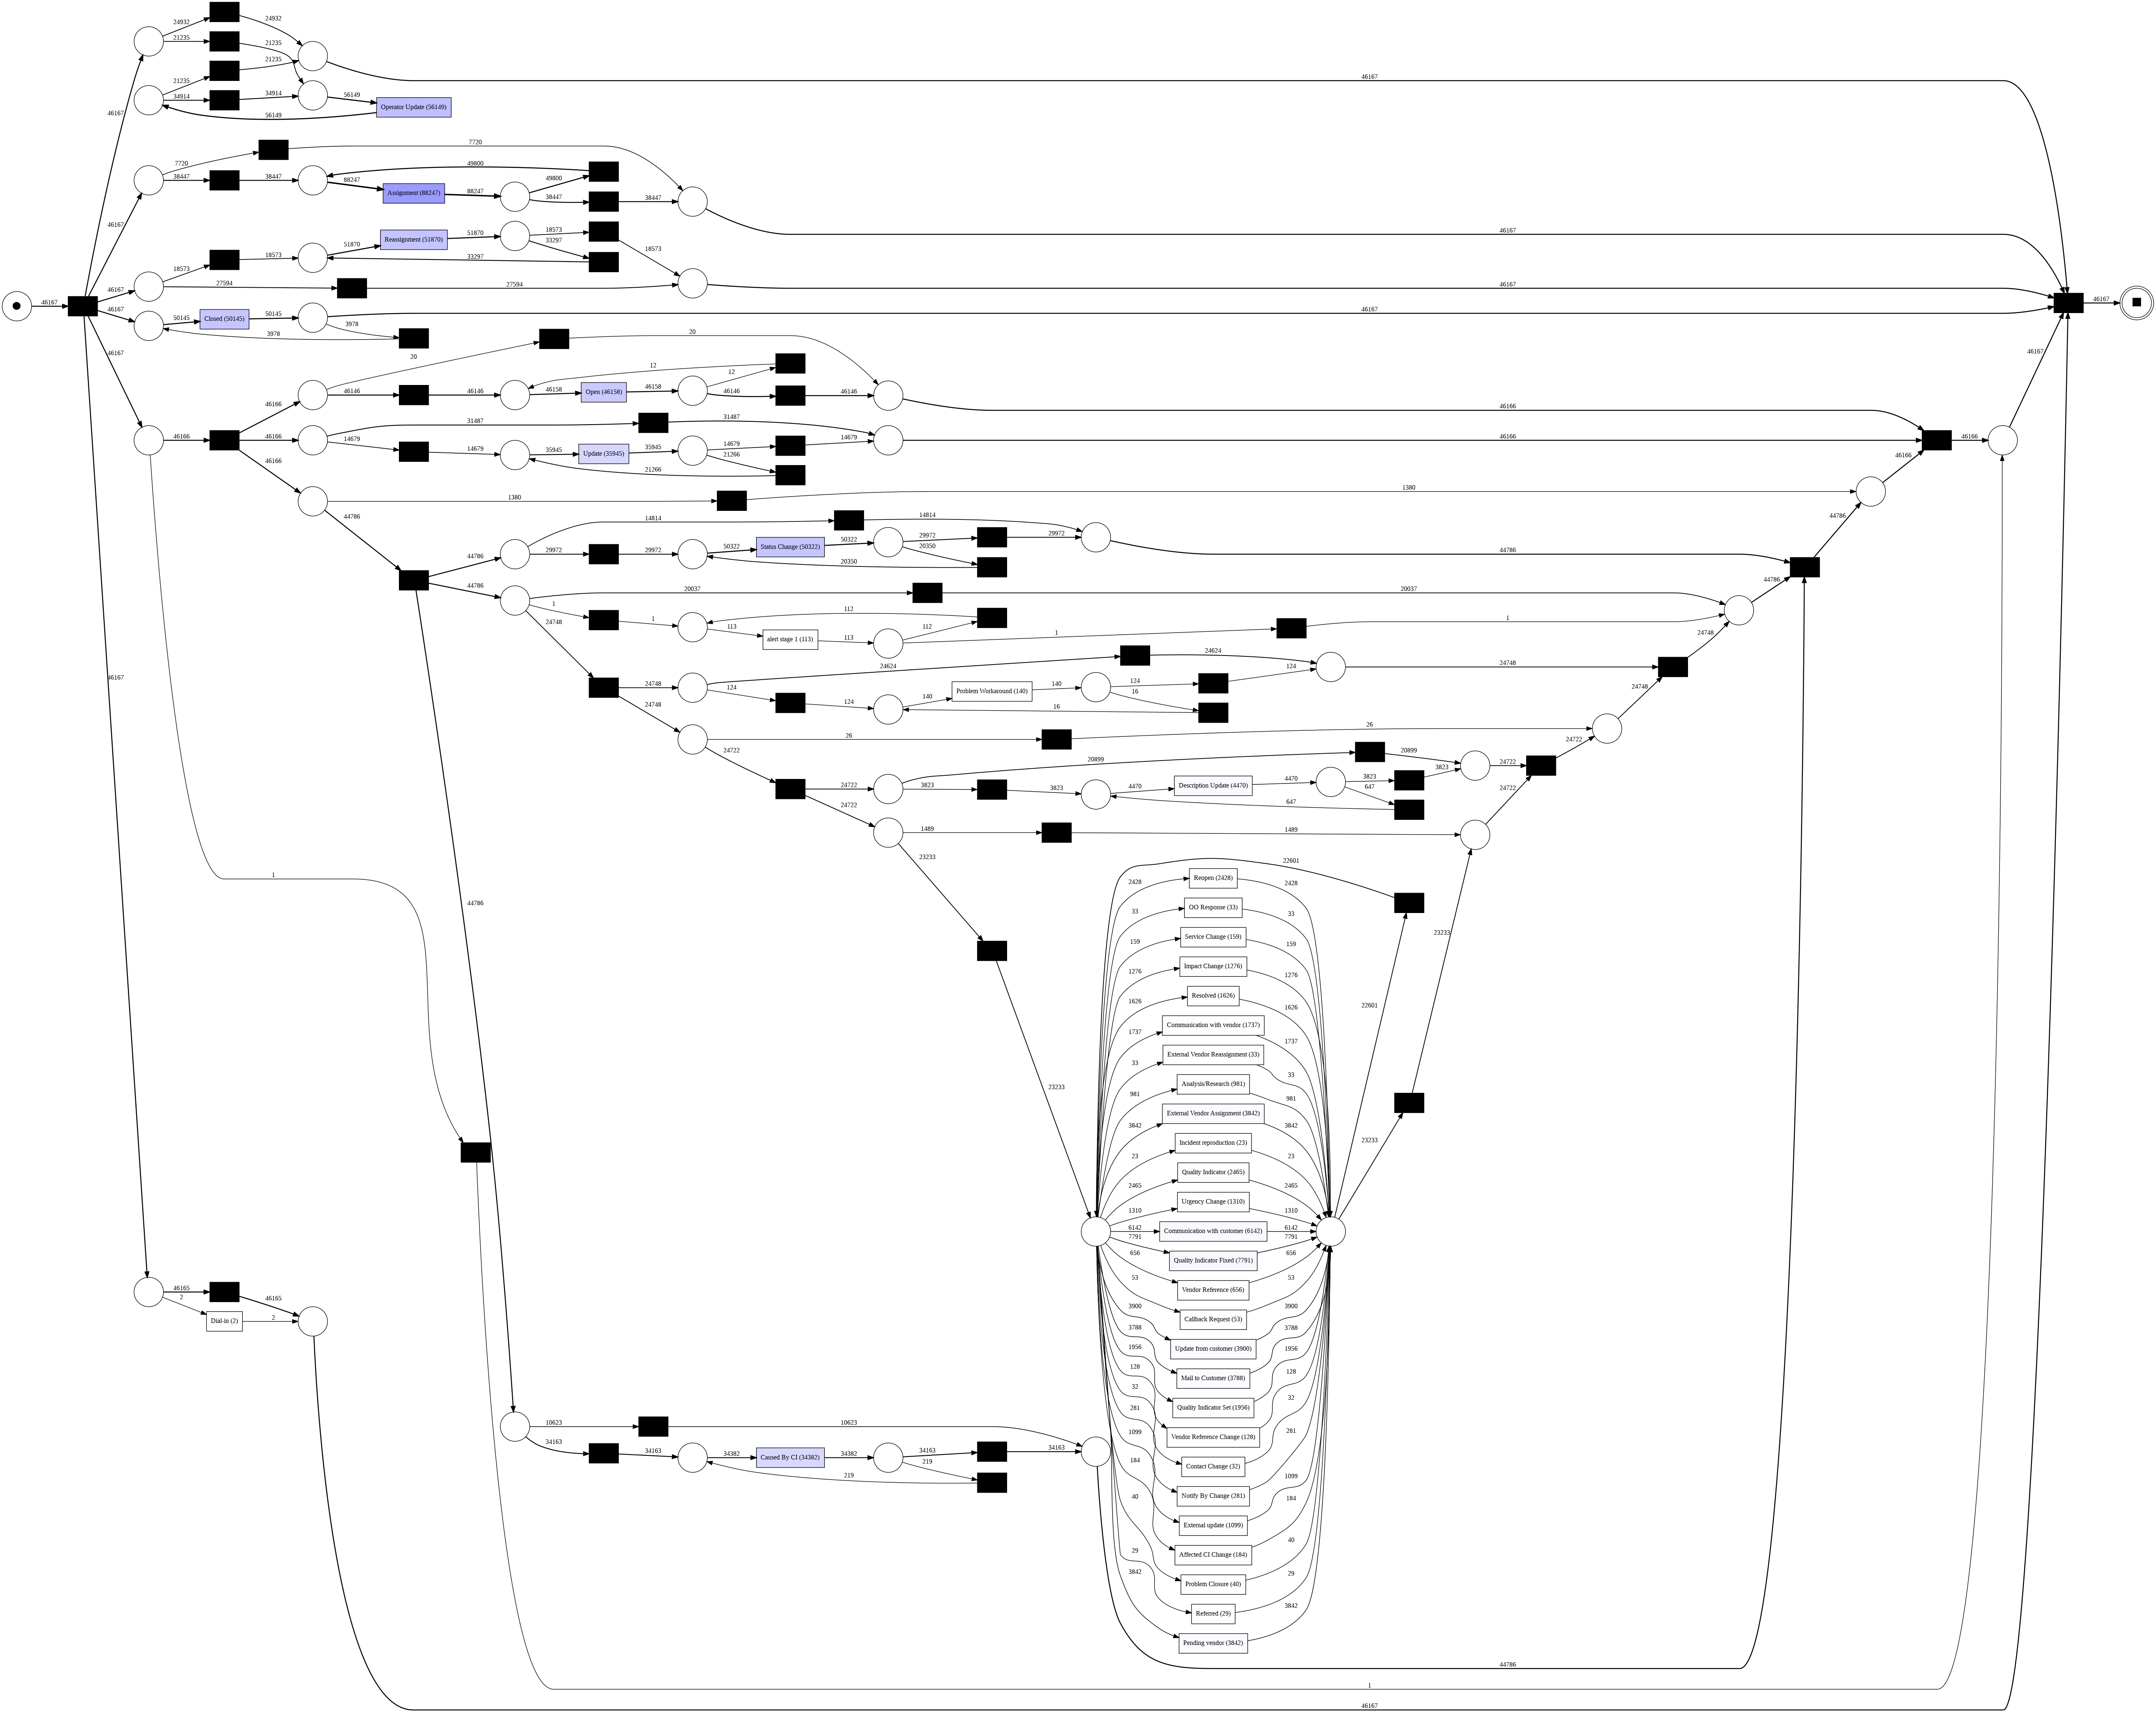

In [ ]:
#inductive miner 
import pm4py
# net, im, fm = inductive_miner.apply(event_log)
net, im, fm = pm4py.discover_petri_net_inductive(event_log)

from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

In [ ]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)
print("Простота: ", simp)

Простота:  0.5460992907801419


In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов: {fitness['average_trace_fitness']}\n")

replaying log with TBR, completed variants ::   0%|          | 0/31389 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов: 1.0



In [ ]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance: {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/246971 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(f"\nТочность с помощью метода Align-ETConformance: {prec}\n")

In [ ]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)


In [ ]:
print(f"\nОбобщение: {gen}\n")

In [ ]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

net1, initial_marking1, final_marking1 = pm4py.discover_petri_net_heuristics(event_log)

gviz1 = pn_visualizer.apply(net1, initial_marking1, final_marking1,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz1)

replaying log with TBR, completed variants ::   0%|          | 0/31389 [00:00<?, ?it/s]

In [ ]:
pn_visualizer.view(gviz1)

In [ ]:
simplicity1 = simplicity_evaluator.apply(net1)
print(f"Простота равна: {simplicity1}\n")

fitness1 = replay_fitness_evaluator.apply(
    event_log, 
    net1, 
    initial_marking1, 
    final_marking1, 
    variant=replay_fitness_evaluator.Variants.TOKEN_BASED,
)
print(f"Пригодность воспроизведения, используя метод на основе токенов, равна {fitness1}\n")

prec1 = precision_evaluator.apply(
    event_log, 
    net1, 
    initial_marking1, 
    final_marking1, 
    variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,
)
print(f"\nТочность с помощью метода ETConformance равна {prec1}\n")

gen1 = generalization_evaluator.apply(
    event_log, 
    net1, 
    initial_marking1, 
    final_marking1,
)
print(f"\nОбобщение равно {gen1}\n")

In [ ]:
gen1 = generalization_evaluator.apply(
    event_log, 
    net1, 
    initial_marking1, 
    final_marking1,
)
print(f"\nОбобщение равно {gen1}\n")